# 1.Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2.Reading Data and Doning Mathematics

In [2]:
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv('../input/iris/Iris.csv')
df2=df.drop('Id', axis=1).copy()

df2.insert(
    0,
    'SepalRatio',
    df2['SepalLengthCm']/df2['SepalWidthCm']
    )

df2.insert(
    1,
    'PetalRatio',
    df2['PetalLengthCm']/df2['PetalWidthCm']
)

df2=df2.drop(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], axis=1)
print(df2['Species'].unique())

LbEnc=LabelEncoder().fit(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']);
df2['Species']=LbEnc.transform(df2[['Species']]);


df2.head()

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,SepalRatio,PetalRatio,Species
0,1.457143,7.0,0
1,1.633333,7.0,0
2,1.468750,6.5,0
3,1.483871,7.5,0
4,1.388889,7.0,0


# 3.Functions

In [3]:
#=========================================================================================================================================================
#======================================================================Functions==========================================================================
#=========================================================================================================================================================


#=====================================================Outlier Elimination by Using DBSCAN Algorithm=======================================================================

def OutlierDetection_DBSCAN(X, Method=('STD'or'IQR'), eps=.5, Threshold=0.1, step=.01, STD=1):
    from sklearn.cluster import DBSCAN
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler

    #----------------------------------------------------------------------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------Data Normlization--------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------

    X=np.asanyarray(X)
    scaler=StandardScaler().fit(X)
    X=scaler.transform(X)

    #----------------------------------------------------------------------------------------------------------------------------------------------------------
    #---------------------------------------------------------Calculating Quartiles and IQR for Each Feature-------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------
    
    if Method=='STD':

      N=len(X[(X[:,0]>=-STD) & (X[:,0]<=STD) & (X[:,1]>=-STD) & (X[:,1]<=STD)])
      R=np.sqrt(2*(2*STD)/np.pi)
      #R=np.sqrt(2*(2*STD))
    
    #----------------------------------------------------------------------------------------------------------------------------------------------------------
    #--------------------------------Calculating The Number of Data in The Range of The IQR of The ALL Features and Calculating Radious-------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------
    
    elif Method=='IQR':
  
      Q1=np.quantile(X, q=0.25, axis=0)
      Q3=np.quantile(X, q=0.75, axis=0)
      IQR=Q3-Q1

      N=len(X[(X[:,0]>=Q1[0]) & (X[:,0]<=Q3[0]) & (X[:,1]>=Q1[1]) & (X[:,1]<=Q3[1])])
      R=np.sqrt(IQR[0]*IQR[1]/np.pi)
      #R=np.sqrt(IQR[0]*IQR[1])

    #----------------------------------------------------------------------------------------------------------------------------------------------------------
    #------------------------------------------------------------Calculating The eps and The min_samples-------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------

    EPS0=eps
    n=np.floor(eps*(N/R)).astype(int)
    Outliers=int(np.zeros(1))
    T=np.array(Threshold)

    #----------------------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------Finding Outliers-------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------------------

    while True:

        DB=DBSCAN(eps=eps, min_samples=n).fit(X)
        LB=DB.labels_

        if (len(LB[LB==-1])<=(Threshold*len(LB))) & (len(LB[LB==-1])!=0):

            Outliers=np.append(Outliers, int(len(LB[LB==-1])))
            
            if Outliers[-1]-Outliers[-2]==0:
                
                print(f'eps={eps:0.4f} | n={n} | Number of Outliers={len(LB[LB==-1])} | Thresholds={T} | Number of Outliers in Each Thresholds={Outliers[1:]}')
                return  scaler.inverse_transform(X), LB

            else:
                Threshold+=step
                T=np.append(T, Threshold)
                eps=EPS0
                n=np.floor(eps*(N/R)).astype(int)
            
        else:
            n=np.floor(n/2).astype(int)
            eps*=2

#==========================================================Outlier Elimination by Using STD=======================================================================

def Outlier(X, Y, I:int=2, figsize1=(10,10), stdx=2, stdy=2):
    
    from sklearn.preprocessing import StandardScaler

    X=np.asanyarray(X)
    Y=np.asanyarray(Y)


    Lb=np.unique(Y)
    J=(np.ceil(len(Lb)/I)).astype(int)

    fig, ax=plt.subplots(I, J, figsize=figsize1)

    for i in range(I):
        for j in range(J):

            if I*i+j<len(Lb):
                X1=StandardScaler().fit_transform(X[Y==Lb[I*i+j]])
                
                ax[i,j].scatter(
                    X1[:, [0]],
                    X1[:, [1]],
                    edgecolors='black', alpha=.5,
                    label=Lb[I*i+j] 
                )
                ax[i,j].set_title(Lb[I*i+j])
                    
            ax[i,j].axhline(stdy, color='red', linestyle='-.')
            ax[i,j].axhline(-stdy, color='red', linestyle='-.')
            ax[i,j].axvline(stdx, color='red', linestyle='-.')
            ax[i,j].axvline(-stdx, color='red', linestyle='-.')
            ax[i,j].set_xlabel('Sepal Ratio')
            ax[i,j].set_ylabel('Petal Ratio');

#=================================================================OutlierElimination=======================================================================

def OutlierElimination(X, Y, I:int=2, stdx=2, stdy=2, figsize1=(10,10), plot=True):

    Lb=np.unique(Y)
    XX=np.zeros((1, np.size(X, axis=1)))
    YY=np.zeros(1)

    for i in Lb:
  
        x=np.asanyarray(X[Y==i])
        y=np.asanyarray(Y[Y==i])

        StdScl=StandardScaler().fit(x)
        x=StdScl.transform(x)

        y=y[((x[:,0]>-stdx) &  (x[:,0]<stdx)) & ((x[:,1]>-stdy) & (x[:,1]<stdy))]
        x=x[((x[:,0]>-stdx) &  (x[:,0]<stdx)) & ((x[:,1]>-stdy) & (x[:,1]<stdy))]

        XX=np.append(XX, StdScl.inverse_transform(x), axis=0)
        YY=np.append(YY, y)
        del x, y
    XX=np.delete(XX, 0, axis=0)
    YY=np.delete(YY, 0)



    if plot:
        J=(np.ceil(len(Lb)/I)).astype(int)

        fig, ax=plt.subplots(I, J, figsize=figsize1)

        for i in range(I):
            for j in range(J):

                if I*i+j<=len(Lb)-1:
                    ax[i,j].scatter(
                        StandardScaler().fit_transform(np.asanyarray(XX[YY==Lb[I*i+j]])[:,[0]]),
                        StandardScaler().fit_transform(np.asanyarray(XX[YY==Lb[I*i+j]])[:,[1]]),
                        edgecolors='black', alpha=.5,
                        label=Lb[I*i+j] 
                    )
                    ax[i,j].set_title(Lb[I*i+j])
                        
                ax[i,j].axhline(stdy, color='red', linestyle='-.')
                ax[i,j].axhline(-stdy, color='red', linestyle='-.')
                ax[i,j].axvline(stdx, color='red', linestyle='-.')
                ax[i,j].axvline(-stdx, color='red', linestyle='-.')
                ax[i,j].set_xlabel('Sepal Ratio')
                ax[i,j].set_ylabel('Petal Ratio');

    return XX, YY

#==================================================================Plot All Classes=========================================================================

def PlotAllClasses(X1, Y1, X2=df2.iloc[:,:2], Y2=df2.iloc[:,2]):

    X1=np.asanyarray(X1)
    Y1=np.asanyarray(Y1).astype(int)
    X2=np.asanyarray(X2)
    Y2=np.asanyarray(Y2).astype(int)

    Lb1=np.unique(Y1)
    Lb2=np.unique(Y2)

    fig, ax=plt.subplots(1, 2, figsize=(12,5) )

    for i in Lb2:
        ax[0].scatter(
            X2[:,0][Y2==i],
            X2[:,1][Y2==i],
            edgecolors='black', alpha=.5,
            label=Lb2[i]
        )
    ax[0].set_title('Before Outlier Elimination')
    ax[0].set_xlabel('Sepal Ratio')
    ax[0].set_ylabel('Petal Ratio')
    ax[0].legend()

    for i in Lb1:
        ax[1].scatter(
            X1[:,0][Y1==i],
            X1[:,1][Y1==i],
            edgecolors='black', alpha=.5,
            label=Lb1[i]
        )
    ax[1].set_title('After Outlier Elimination')
    ax[1].set_xlabel('Sepal Ratio')
    ax[1].set_ylabel('Petal Ratio')
    ax[1].legend();   

#======================================================================SVM Plot============================================================================

def SVM_plot(X, Y, Model, Lines=[0], Styles=['-'], AreaCmap='Set1', DataCmap='Paired', Xlabel='X1', Ylabel='X2'):
    import numpy as np
    import matplotlib.pyplot as plt

    xx3=np.linspace(X[:,0].min(), X[:,0].max(), 500)
    xx4=np.linspace(X[:,1].min(), X[:,1].max(), 500)

    xx3, xx4=np.meshgrid(xx3, xx4)
    XX34=np.c_[xx3.flatten(), xx4.flatten()]

    P4=Model.predict(XX34).reshape(xx3.shape)
    P41=Model.decision_function(XX34).reshape(xx3.shape)

    plt.contour(
        xx3,
        xx4,
        P41, levels=Lines, linestyles=Styles, colors='k'
    )

    plt.contourf(
        xx3,
        xx4,
        P4,
        cmap=AreaCmap
    )

    plt.scatter(
        X[:,0],
        X[:,1],
        c=Y, cmap=DataCmap, edgecolors='black'
    )

    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel);

#==================================================================Plot Cross Vlidation=======================================================================

def plot_cv_indices(cv, X, y, n_splits, group, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    fig, ax = plt.subplots(figsize=(15, 5))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):#, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap='coolwarm',
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap='Paired'
    )

    if group:
        ax.scatter(
            range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap='Paired'
        )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax, plt.show()

#================================================================Cross_Validation_Modeling=======================================================================

def Cross_Validation_Modeling(X, Y, CV, classifier, Print=True, Plot=False):

    from sklearn.metrics import roc_auc_score, accuracy_score

    AUC_trn=np.array([])
    accuracy_trn=np.array([])

    AUC_val=np.array([])
    accuracy_val=np.array([])

    for K, (trn, val) in enumerate(CV.split(X, Y)):
        
        X_trn=X[trn]
        Y_trn=Y[trn]

        X_val=X[val]
        Y_val=Y[val]

        clf=classifier.fit(X_trn, Y_trn)

        ##------------------------------------------------ROC and Accuracy on Validation DAta---------------------------------------------------------------------

        auc_val=roc_auc_score(Y_val, clf.predict_proba(X_val)[:,-1])
        accu_val=accuracy_score(Y_val, clf.predict(X_val))
        
        AUC_val=np.append(AUC_val, auc_val)
        accuracy_val=np.append(accuracy_val, accu_val)

        ##------------------------------------------------ROC and Accuracy on Train DAta---------------------------------------------------------------------

        auc_trn=roc_auc_score(Y_trn, clf.predict_proba(X_trn)[:,-1])
        accu_trn=accuracy_score(Y_trn, clf.predict(X_trn))

        AUC_trn=np.append(AUC_trn, auc_trn)
        accuracy_trn=np.append(accuracy_trn, accu_trn)

        if Print:
            print(f'===================== K={K+1} =======================')
            print('------------------ Vlidation --------------------')
            print(f"Accuracy= {accu_val:0.4f} \t\t AUC= {auc_val:0.4f}")
            print('-------------------- Train ----------------------')
            print(f"Accuracy= {accu_trn:0.4f} \t\t AUC= {auc_trn:0.4f}")
            #print('\n')

    AUC_val_mean=AUC_val.mean()
    accuracy_val_mean=accuracy_val.mean()
    AUC_trn_mean=AUC_trn.mean()
    accuracy_trn_mean=accuracy_trn.mean()

    AUC_val_std=AUC_val.std()
    accuracy_val_std=accuracy_val.std()
    AUC_trn_std=AUC_trn.std()
    accuracy_trn_std=accuracy_trn.std()

    if Plot:
        Xticklabels=np.arange(1,len(list(CV.split(X, Y)))+1)
        x=np.arange(1,len(list(CV.split(X, Y)))+1).astype(int)
        Xticks=x

        fig, ax= plt.subplots(2, 2, figsize=(12,12))
        ax[0,0].plot(x, accuracy_val, 'k')
        ax[0,0].axhline(accuracy_val_mean, color='red', linestyle='-.')

        ax[0,0].set(
            title=f'Validation\nAccuracy Average={accuracy_val_mean:0.4f}, STD={accuracy_val_std:0.4f}',
            xticks=Xticks,
            xlabel="K",
            ylabel="Accuracy",
        )


        ax[0,1].plot(x, AUC_val, 'k')
        ax[0,1].axhline(AUC_val_mean, color='red', linestyle='-.')

        ax[0,1].set(
            title=f'Validation\nAverage AUC={AUC_val_mean:0.4f}, STD={AUC_val_std:0.4f}',
            xticks=Xticks,
            xlabel="K",
            ylabel="AUC",
        )


        ax[1,0].plot(x, accuracy_trn, 'k')
        ax[1,0].axhline(accuracy_trn_mean, color='red', linestyle='-.')

        ax[1,0].set(
            title=f'Train\nAverage Accuracy={accuracy_trn_mean:0.4f}, STD={accuracy_trn_std:0.4f}',
            xticks=Xticks,
            xlabel="K",
            ylabel="Accuracy",
        )


        ax[1,1].plot(x, AUC_trn, 'k')
        ax[1,1].axhline(AUC_trn_mean, color='red', linestyle='-.')

        ax[1,1].set(
            title=f'Train\nAverage AUC={AUC_trn_mean:0.4f}, STD={AUC_trn_std:0.4f}',
            xticks=Xticks,
            xlabel="K",
            ylabel="AUC",
        )

    return accuracy_val, AUC_val, accuracy_trn, AUC_trn

#==========================================================Train Test Split Equally from Each Class===============================================================

def class_train_test_split(X, Y, test_size=.2):
    from sklearn.model_selection import train_test_split
    
    Xtrain=np.zeros((1, X.shape[1]))
    Xtest=np.zeros((1, X.shape[1]))
    Ytrain=np.array([])
    Ytest=np.array([])

    for i in np.unique(Y):
        XXtrain, XXtest, YYtrain, YYtest=train_test_split(X[Y==i], Y[Y==i], test_size=test_size, random_state=1)

        Xtrain=np.vstack([Xtrain, XXtrain])
        Xtest=np.vstack([Xtest, XXtest])

        Ytrain=np.hstack([Ytrain, YYtrain])
        Ytest=np.hstack([Ytest, YYtest])

    Xtrain=np.delete(Xtrain, 0, axis=0)
    Xtest=np.delete(Xtest, 0, axis=0)

    return Xtrain, Xtest, Ytrain, Ytest



# 4.Outlier Detection & Elimination

eps=1.0000 | n=5 | Number of Outliers=6 | Thresholds=[0.1  0.12 0.14] | Number of Outliers in Each Thresholds=[1 6 6]
eps=1.0000 | n=7 | Number of Outliers=4 | Thresholds=[0.1  0.12] | Number of Outliers in Each Thresholds=[4 4]
eps=1.0000 | n=5 | Number of Outliers=1 | Thresholds=[0.1  0.12] | Number of Outliers in Each Thresholds=[1 1]


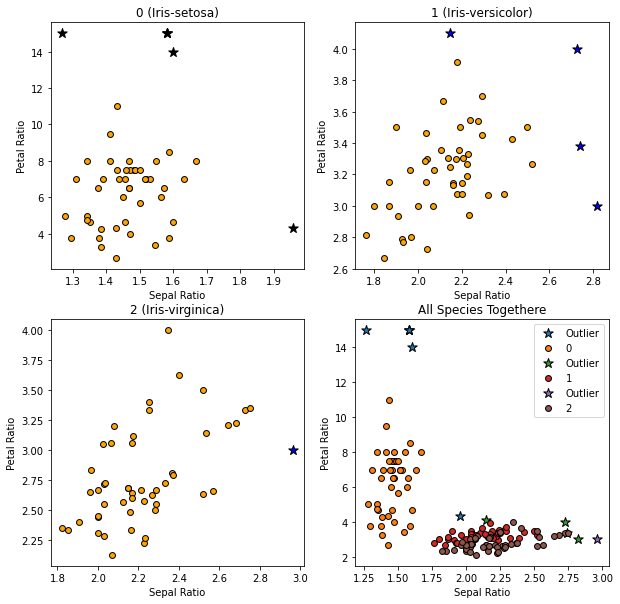

In [4]:
x0, lb0=OutlierDetection_DBSCAN(df2[['SepalRatio', 'PetalRatio']][df2['Species']==0], Method='IQR', Threshold=0.1, step=0.02)

x1, lb1=OutlierDetection_DBSCAN(df2[['SepalRatio', 'PetalRatio']][df2['Species']==1], Method='IQR', Threshold=0.1, step=0.02)

x2, lb2=OutlierDetection_DBSCAN(df2[['SepalRatio', 'PetalRatio']][df2['Species']==2], Method='STD', STD=1, Threshold=0.1, step=0.02)


lb=np.hstack([lb0, lb1, lb2])
X=np.vstack([x0, x1, x2])
Y=np.asanyarray(df2['Species'])


fig, ax=plt.subplots(2, 2, figsize=(10, 10))
for i in np.unique(lb0):
    ax[0, 0].scatter(
        x0[:, 0][lb0==i],
        x0[:, 1][lb0==i],
        color='black' if i==-1 else 'orange',
        edgecolors='black',  
        marker='*' if i==-1 else 'o',
        s=100 if i==-1 else 35)

ax[0, 0].set(
    xlabel='Sepal Ratio',
    ylabel='Petal Ratio',
    title='0 (Iris-setosa)'
)



for i in np.unique(lb1):
    ax[0, 1].scatter(
        x1[:, 0][lb1==i], 
        x1[:, 1][lb1==i],
        color='blue' if i==-1 else 'orange',
        edgecolors='black',  
        marker='*' if i==-1 else 'o',
        s=100 if i==-1 else 35)

ax[0, 1].set(
    xlabel='Sepal Ratio',
    ylabel='Petal Ratio',
    title='1 (Iris-versicolor)'
)



for i in np.unique(lb2):
    ax[1, 0].scatter(
        x2[:, 0][lb2==i], 
        x2[:, 1][lb2==i],
        color='blue' if i==-1 else 'orange',
        edgecolors='black',
        marker='*' if i==-1 else 'o',
        s=100 if i==-1 else 35)

ax[1, 0].set(
    xlabel='Sepal Ratio',
    ylabel='Petal Ratio',
    title='2 (Iris-virginica)'
)



for i in np.unique(Y):    
    for j in np.unique(lb):
        ax[1, 1].scatter(
            X[:, 0][(Y==i) & (lb==j)],
            X[:, 1][(Y==i) & (lb==j)],
            label=i if j!=-1 else 'Outlier',
            cmap='Paired', edgecolors='black',
            marker='*' if j==-1 else 'o',
            s=100 if j==-1 else 35
        )
        
ax[1, 1].legend()
ax[1, 1].set(
    xlabel='Sepal Ratio',
    ylabel='Petal Ratio',
    title='All Species Togethere'
);  


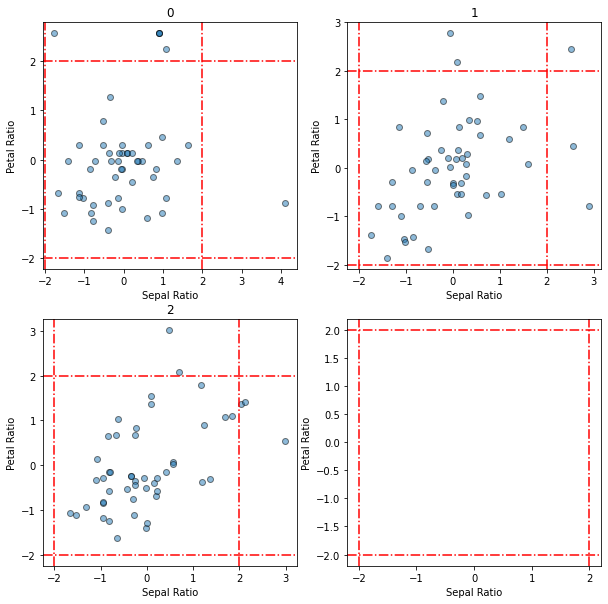

In [5]:
Outlier(X, Y)

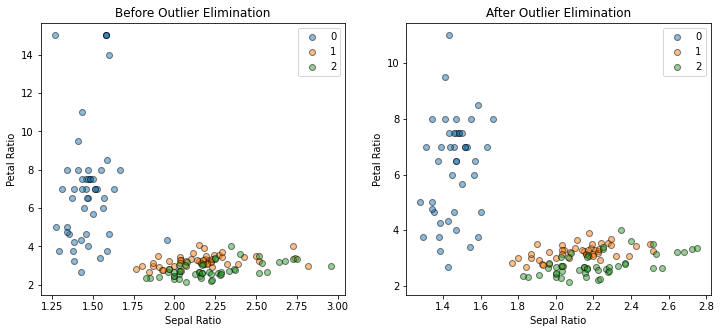

In [6]:
X=X[lb!=-1]
Y=Y[lb!=-1]
PlotAllClasses(X, Y)

# 5.Train Test Split Data

### 5.1.Classification Between Calss 0 and The Rest of The Dataset

#### 5.1.1.Train Test Split and Normalization

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


Y1=Y.copy()
X1=X.copy()

Y1[Y!=0]=1

#-----------------------------------------Making Train and Test Subset Equally from All Classes---------------------------------------------------------------------

xxtrain1, xxtest1, yytrain1, yytest1 = train_test_split(X1[Y1==0], Y1[Y1==0], test_size=.2, random_state=0, shuffle=True)
xxtrain2, xxtest2, yytrain2, yytest2 = train_test_split(X1[Y1!=0], Y1[Y1!=0], test_size=.2, random_state=0, shuffle=True)

xtrain1=np.vstack([xxtrain1, xxtrain2])
xtest1=np.vstack([xxtest1, xxtest2])

#------------------------------Making Final Train and Test Subset by Sticking Two Prvious Train Test Subsets-------------------------------------------------------

Ytrain1=np.hstack([yytrain1, yytrain2])
Ytest1=np.hstack([yytest1, yytest2])

##------------------------------------------------Standard Normalisation Based on Train Data---------------------------------------------------------------------

StSc1=StandardScaler().fit(xtrain1)
Xtrain1=StSc1.transform(xtrain1)
Xtest1=StSc1.transform(xtest1)

#### 5.1.2.Stratified K-Fold Cross-Validation and SVM Modeling

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score

SKF1=StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

Cross_Validation_Modeling(Xtrain1, Ytrain1, SKF1, SVC(kernel='linear', probability=True))
SVM1=SVC(kernel='linear', probability=True).fit(Xtrain1, Ytrain1)

===================== K=1 =======================
------------------ Vlidation --------------------
Accuracy= 1.0000 		 AUC= 1.0000
-------------------- Train ----------------------
Accuracy= 1.0000 		 AUC= 1.0000
===================== K=2 =======================
------------------ Vlidation --------------------
Accuracy= 1.0000 		 AUC= 1.0000
-------------------- Train ----------------------
Accuracy= 1.0000 		 AUC= 1.0000
===================== K=3 =======================
------------------ Vlidation --------------------
Accuracy= 1.0000 		 AUC= 1.0000
-------------------- Train ----------------------
Accuracy= 1.0000 		 AUC= 1.0000
===================== K=4 =======================
------------------ Vlidation --------------------
Accuracy= 1.0000 		 AUC= 1.0000
-------------------- Train ----------------------
Accuracy= 1.0000 		 AUC= 1.0000


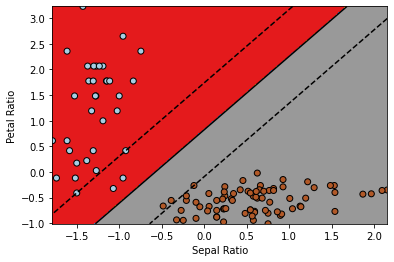

In [9]:
SVM_plot(Xtrain1, Ytrain1, SVM1, Lines=[-1,0,1], Styles=['--', '-', '--'], Xlabel='Sepal Ratio', Ylabel='Petal Ratio')

### 5.2.Classification Between Calss 1 and 2

#### 5.2.1.Train Test Split and Normalization

In [10]:
from sklearn.preprocessing import StandardScaler

Y2=Y[Y!=0].copy()
X2=X[Y!=0].copy()

Y2[Y2==1]=0
Y2[Y2==2]=1

Xtrain2, Xtest2, Ytrain2, Ytest2=class_train_test_split(X2, Y2, test_size=.2)

StSc2=StandardScaler().fit(Xtrain2)

Xtrain2=StSc2.transform(Xtrain2)
Xtest2=StSc2.transform(Xtest2)


#### 5.2.2.Finding The Best Model and Hyperparameter Tuning With Stratified K-Fold Cross-Validation

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


clf=(
    (SVC(), {'kernel':[ 'poly', 'rbf'], 'C':np.arange(5, 10, step=1), 'gamma':['scale', 'auto']}),
    
    (LogisticRegression(), {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C':np.arange(1, 50, step=5)}),

    (KNeighborsClassifier(), {'n_neighbors':np.arange(5, 11), 'weights':['uniform', 'distance']}),

    (RandomForestClassifier(), {'n_estimators':np.arange(100, 351, step=50), 'criterion':['gini', 'entropy']})
)

CLF={}

for model, prams in clf:
    gridT=GridSearchCV(
        estimator=model,
        param_grid=prams,
        cv=5)

    gridT.fit(Xtrain2, Ytrain2)

    CLF[str(model)]=gridT.best_params_
    CLF[str(model)]['Score']=gridT.best_score_

pd.DataFrame(CLF).fillna('----')

,SVC(),LogisticRegression(),KNeighborsClassifier(),RandomForestClassifier()
C,5,1,----,----
gamma,scale,----,----,----
kernel,rbf,----,----,----
Score,0.84,0.84,0.853333,0.76
solver,----,newton-cg,----,----
n_neighbors,----,----,9,----
weights,----,----,uniform,----
criterion,----,----,----,entropy
n_estimators,----,----,----,250


#### 5.2.3.The More Detailed Review of SVM Model With Different C Parameter

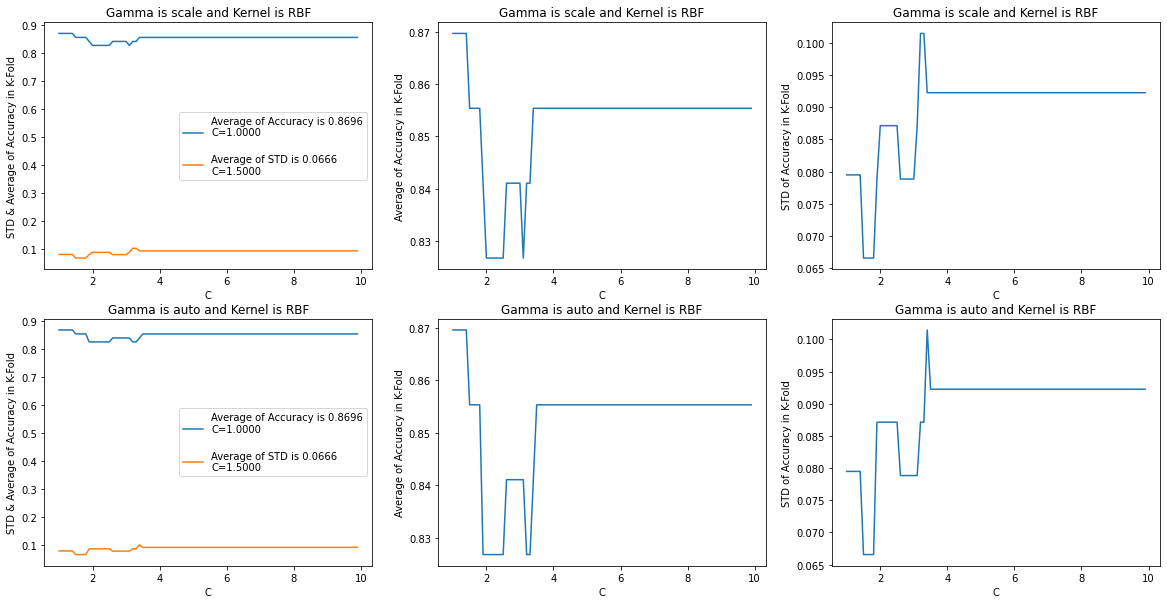

In [12]:
from sklearn.model_selection import cross_val_score


C=np.arange(1, 10, step=0.1)
Gamma=['scale', 'auto'] #[.5, 1, 5]


performance_mean=np.zeros((len(Gamma), len(C)))    #Average of Accuracy Parameter in Cross_Vvalidation
performance_std=np.zeros((len(Gamma), len(C)))     #Average of STD of Accuracy parametr in Cross_Validation


fig, ax=plt.subplots(len(Gamma), 3, figsize=(20, len(Gamma)*5))

for d, D in enumerate(Gamma):

    performance_val_mean=np.array([])
    performance_val_std=np.array([])

 ##-------------------------------------------------------------------------------------------------------------------------------------------------------------
 ##------------------------------------------------------------Making Model and Cross_Validation--------------------------------------------------------------------------------
 ##-------------------------------------------------------------------------------------------------------------------------------------------------------------

    for i in C:
        SVM_validation=SVC(kernel='rbf', gamma=D, C=i, probability=True)

        #accu_val, auc_val, accu_trn, auc_trn=Cross_Validation_Modeling(Xtrain2, Ytrain2, SKF2, SVM_validation, Plot=False, Print=False)
        accu_val=cross_val_score(SVM_validation, Xtrain2, Ytrain2, cv=10)

        performance_val_mean=np.append(performance_val_mean, accu_val.mean())   #Average of Accuracy in Each Cross_Validation for Validation Data
        performance_val_std=np.append(performance_val_std, accu_val.std())      #Average of STD of Accuracy in Each Cross_Validation for Validation Data

 ##-------------------------------------------------------------------------------------------------------------------------------------------------------------
 ##----------------------------------------------------------Making Matrix of Average Accuracy and STD--------------------------------------------------------------------------------
 ##-------------------------------------------------------------------------------------------------------------------------------------------------------------

    performance_mean[d,:]=performance_val_mean
    performance_std[d,:]=performance_val_std

    best_mean=performance_mean[d,:].max()               ##Maximum Accuracy
    C_best_mean=C[np.argmax(performance_mean[d,:])]     ##The Best C Based on Maximum Accuracy

    best_std=performance_std[d,:].min()                 ##Minimum STD of Accuracy
    C_best_std=C[np.argmin(performance_std[d,:])]       ##The best C Based on Minimum of STD of Accuracy
 



 ##-------------------------------------------------------------------------------------------------------------------------------------------------------------
 ##------------------------------------------------------------------------Plotting Data--------------------------------------------------------------------------------
 ##-------------------------------------------------------------------------------------------------------------------------------------------------------------


 ##---------------------------------------------------------Plotting Both Avrage of Accuracy and STD Together--------------------------------------------------------------------------------

    ax[d,0].plot(C, performance_val_mean, label=f'Average of Accuracy is {best_mean:0.4f}\nC={C_best_mean:0.4f}\n')
    ax[d,0].plot(C, performance_val_std, label=f'Average of STD is {best_std:0.4f}\nC={C_best_std:0.4f}')
    ax[d,0].legend()
    ax[d,0].set(
        xlabel='C',
        ylabel='STD & Average of Accuracy in K-Fold',
        title=f'Gamma is {D} and Kernel is RBF'
    )

 ##------------------------------------------------------------------Plotting Avrage of Accuracy--------------------------------------------------------------------------------

    ax[d,1].plot(C, performance_val_mean)
    ax[d,1].set(
        xlabel='C',
        ylabel='Average of Accuracy in K-Fold',
        title=f'Gamma is {D} and Kernel is RBF'
    )

 ##--------------------------------------------------------------------Plotting Avrage of STD--------------------------------------------------------------------------------

    ax[d,2].plot(C, performance_val_std)
    ax[d,2].set(
        xlabel='C',
        ylabel='STD of Accuracy in K-Fold',
        title=f'Gamma is {D} and Kernel is RBF'
    )



Accuracy of Test Data is 0.8000
Accuracy of Train Data is 0.8933


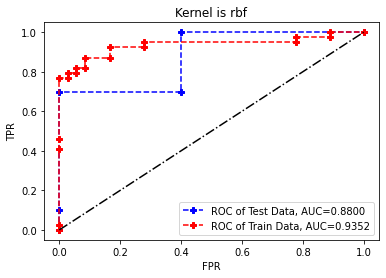

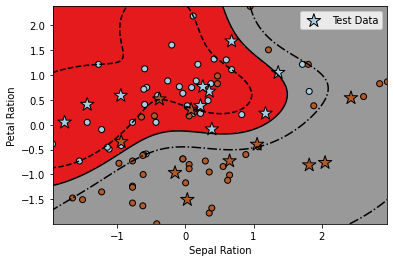

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score


Kernel='rbf'
SVM2=SVC(kernel=Kernel, gamma='scale', C=5, probability=True).fit(Xtrain2, Ytrain2)

##-------------------------------------------------------------------------------------------------------------------------------------------------------------
##------------------------------------------------------------Calculating Accuracy--------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------

Accuracy_ts=accuracy_score(Ytest2, SVM2.predict(Xtest2))
Accuracy_tr=accuracy_score(Ytrain2, SVM2.predict(Xtrain2))

print(f'Accuracy of Test Data is {Accuracy_ts:0.4f}')
print(f'Accuracy of Train Data is {Accuracy_tr:0.4f}')

##-------------------------------------------------------------------------------------------------------------------------------------------------------------
##---------------------------------------------------------------ROC Curve Data--------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------

AUC2_ts=roc_auc_score(Ytest2, SVM2.predict_proba(Xtest2)[:, 1])
AUC2_tr=roc_auc_score(Ytrain2, SVM2.predict_proba(Xtrain2)[:,1])

fpr_ts, tpr_ts, threshold_ts = roc_curve(Ytest2, SVM2.predict_proba(Xtest2)[:, 1])
fpr_tr, tpr_tr, threshold_tr = roc_curve(Ytrain2, SVM2.predict_proba(Xtrain2)[:,1])

##-------------------------------------------------------------------------------------------------------------------------------------------------------------
##---------------------------------------------------------------ROC Curve Plot--------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.plot(fpr_ts, tpr_ts, 'b--P', label=f'ROC of Test Data, AUC={AUC2_ts:0.4f}')
plt.plot(fpr_tr, tpr_tr, 'r--P', label=f'ROC of Train Data, AUC={AUC2_tr:0.4f}')
plt.plot([0, 1], [0, 1], 'k-.')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title(f'Kernel is {Kernel}');

##-------------------------------------------------------------------------------------------------------------------------------------------------------------
##-----------------------------------------------------------------SVM Countour--------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.figure()
SVM_plot(
    Xtrain2, Ytrain2,
    SVM2,
    Lines=[-1, 0, 1], Styles=['--', '-', '-.'],
    Xlabel='Sepal Ration',
    Ylabel='Petal Ration'
)

##-------------------------------------------------------------------------------------------------------------------------------------------------------------
##---------------------------------------------------------Test Data on The Curve Contour--------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.scatter(
    Xtest2[:,0], Xtest2[:,1],
    cmap='Paired', c=Ytest2,
    s=200, marker='*', edgecolors='k',
    label='Test Data'   
)

plt.legend();

# FINISH